In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import numpy as np
import os

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device.type}')

Device used: cpu


# Hyperparameters for project

In [67]:
train_size = 0.7
test_size = 1 - train_size
num_epochs = 5
batch_size = 4
learning_rate = 0.001

# Data preprocessing


## Import the dataset
Dataset should be imported as a pytorch dataloader for batch optimization

(6400, 128, 128)


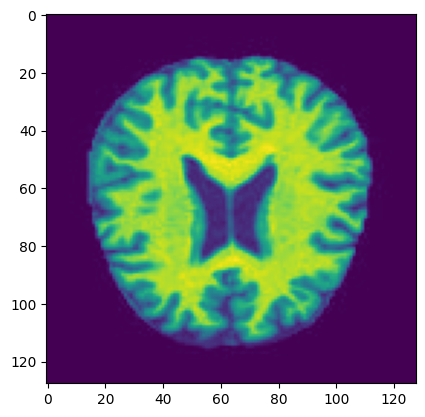

In [78]:
# Create an empty array to store the image arrays and class
X = []
Y = []

# Define the folder paths containing the images
folder_paths = ['Dataset/Non_Demented/', 'Dataset/Very_Mild_Demented/', 'Dataset/Mild_Demented/', 'Dataset/Moderate_Demented/']
classes = [r'Non demented', r'Very mildly demented', r'mild demented', r'moderate demented']

# Loop over the images to save them in the list
for c, path in enumerate(folder_paths):
    items = os.listdir(path)
    for picture in items:
        file_path = os.path.join(path, picture)
        # Open the image and convert it to a NumPy array
        img = Image.open(file_path)
        array_representation = np.asarray(img)

        # Append the NumPy array to the list
        X.append(array_representation)
        Y.append(c)

# Convert the list of image arrays to a NumPy array
image_array = np.array(X)

# Shape of the array
print(image_array.shape)

# Display first image in array
plt.imshow(X[0])

In [79]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2

# Assuming you have a class named MyDataset for your dataset
class MyDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.Y[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

# Define transformations, you can adjust these based on your needs
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True)
])

# Create an instance of your dataset
dataset = MyDataset(X=image_array, Y=Y, transform=transform)

### Split into Test/Training sets

In [80]:
train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [int(train_size * len(dataset)), len(dataset) - int(train_size * len(dataset))]
    )

# Define DataLoader for training and test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Show example of dataset

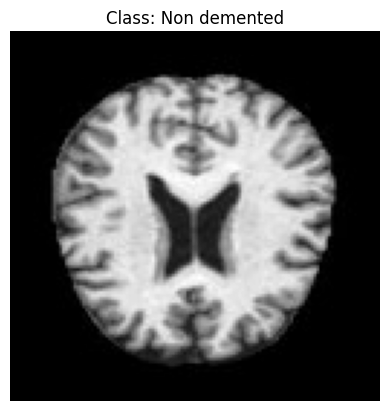

In [81]:
index_to_display = 0  # Image to show in dataset

# Get the image array and corresponding class
selected_image = image_array[index_to_display]
selected_class = classes[Y[index_to_display]]

# Display the image
plt.imshow(selected_image, cmap='gray')
plt.title(f'Class: {selected_class}')
plt.axis('off')  # Turn off axis labels
plt.show()

## **Data augmentation**

To augment the data before training, we will attempt to use two methods:


1.   Scaling
> Scaling is used because we wish to taken into account the varying structure size of tumors and skulls in the images.

2.   Noise Injection
> Noise injection is used to help assist the model in learning the complex patterns around the tumors and make it more robust to small changes in the data.
> We will experiment with both Gaussian (random), and salt-and-paper (random values to min. or max. values, 0 to 255) noise injection.

All combinations of these will be used to determine their effectiveness, and if they introduce any *bias*, *artifacts*, or *overfitting* both in isolation, or combination.

The order of the data augmentation will be:
1.   No Data Augmentation
2.   Scaling
3.   Noise Injection
4.   Scaling, Noise Injection

Image and shape before transformation: torch.Size([1, 128, 128])
Image and shape after transformation (scale and gaussian noise): torch.Size([1, 256, 256])


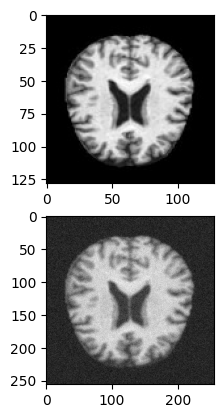

In [98]:
from torchvision.transforms import v2

aug_X = np.array(X)
# In the shape of (Sample #, Height, Width, Channels)
aug_X = aug_X.reshape(len(X), 128, 128, 1)

def add_noise_gaussian(tensor, mean = 0, std = 0.05):
    """
    Parameters:
    - tensor: PyTorch tensor data type without noise (input)
    - mean: Mean of the Gaussian distribution
    - std: Standard deviation of the Gaussian distribution

    Returns:
    - tensor + noise: PyTorch tensor data type with noise (output)
    """

    noise = torch.randn(tensor.size()) * std + mean
    return tensor + noise

def add_noise_salt_pepper(tensor, salt_prob = 0.02, pepper_prob = 0.02):
    """
    Parameters:
    - tensor: PyTorch tensor data type without noise (input)
    - salt_prob: Probability that salt noise is added (full white)
    - pepper_prob: Probability that pepper noise is added (full black)

    Returns:
    - tensor + salt_mask = pepper_mask: PyTorch tensor data type with noise (output)
    that ensured to be between 0 and 1
    """

    salt_mask = (torch.rand_like(tensor) < salt_prob).float()
    pepper_mask = (torch.rand_like(tensor) < pepper_prob).float()

    return torch.clamp((tensor + salt_mask - pepper_mask), 0, 1)

# Abitrary values (set to double of base image height*width)
resize_x = 256
resize_y = 256

# Set resize_x and resize_y before using these transforms
# All transforms convert it to a tensor with the dimensions of (Channels, Height, Width)
transforms = {
    'none': v2.Compose([
                        v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True)
                        ]),
    'scale': v2.Compose([
                        v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Resize((resize_x, resize_y), antialias=True)
                        ]),
    'noise_gaussian': v2.Compose([
                        v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Lambda(lambda x: add_noise_gaussian(x))
                        ]),
    'noise_salt_pepper': v2.Compose([
                        v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Lambda(lambda x: add_noise_salt_pepper(x))
                        ]),
    'all_gaussian':     v2.Compose([
                        v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Resize((resize_x, resize_y), antialias=True),
                        v2.Lambda(lambda x: add_noise_gaussian(x))
                        ]),
    'all_salt_pepper':  v2.Compose([
                        v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Resize((resize_x, resize_y), antialias=True),
                        v2.Lambda(lambda x: add_noise_salt_pepper(x))
                        ])
}

in_img = transforms['none'](X[0])
out_img = transforms['all_gaussian'](X[0])


f, axarr = plt.subplots(2,1)

print(f'Image and shape before transformation: {in_img.shape}')
axarr[0].imshow(in_img.squeeze(), cmap='gray')

print(f'Image and shape after transformation (scale and gaussian noise): {out_img.shape}')
axarr[1].imshow(out_img.squeeze(), cmap='gray')


## Data normalization

# Architecture of the network